# RAPIDS Customized Kernel Tutorial

### RAPIDS overview

The RAPIDS suite of software libraries, built on CUDA-X AI, gives you the freedom to execute end-to-end data science and analytics pipelines entirely on GPUs. 

![RAPIDS components](https://rapids.ai/assets/images/Pipeline-FPO-Diagram.png)

`cuDF` is the library that is similar to `Pandas` library. It accelerates the Dataframe operations in the GPU. `cuDF` is an on going project that a lot of important dataframe functions are missinng. One solution is to build customized GPU kernels to implement them.

This tutorial will show how to do this with different methods ordered by implmentation difficulties. It is organized as:

1. Customized Kernel by RAPIDS API
2. Customized Kernel by NUMBA library
3. Customized Kernel by CuPy library
4. Summary 

### Toy Problem, compute the distance of points to the origin

The toy problem is to compute the distance of the list of points in 2-D space to the origin. First generate 1000 random points and load them to the GPU dataframe

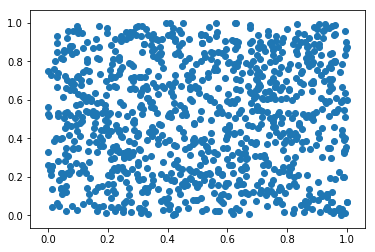

In [1]:
%matplotlib inline 
import cudf
import numpy as np
import math
from numba import cuda
import cupy
import matplotlib.pyplot as plt
 
# construct the dataframe to store x and y coordinates of the points
df = cudf.DataFrame()
df['x'] = np.random.rand(1000)
df['y'] = np.random.rand(1000)
# visualize the points
plt.figure()
plt.scatter(df['x'], df['y'])
plt.show()

Compute the ground truth distance by RAPIDS calls. And define the validation function to make sure the result matchs the ground truth for later use

In [2]:
df['ground_truth'] = cudf.sqrt(df['x']**2 + df['y']**2)
# function to verify the results
def verify(ground_truth, computed):
    max_difference = cudf.sqrt((ground_truth - computed)**2).max()
    assert(max_difference < 1e-8)
    return max_difference
print(df)

                     x                    y         ground_truth
0   0.9252928634613055    0.992812422072358   1.3571453085773844
1  0.21193760016759378  0.04594854462885045  0.21686128081865677
2  0.17153809034311562   0.8142726298283021    0.832144958601602
3   0.7619357566322866   0.6863139914857838   1.0254623309239417
4   0.2768837816871409   0.7879175603671916    0.835151908634806
5   0.3474108508528436   0.5910867539052965   0.6856222355879347
6   0.5295790684947622   0.6188912212869327   0.8145430213155173
7   0.8299506729081547   0.9144116587032217   1.2348954615808887
8   0.9165439761903346   0.3028774802123806   0.9652914732403832
9   0.5536590775955167   0.7561741191191867   0.9371967096771074
[990 more rows]


### Customized Kernel by RAPIDS API

This is the easiest way to customize your computations.

Introduce two functions:
* apply_rows
* apply_chunks

`apply_rows` processes each of the rows of the Dataframe independently in parallel. Under the hood, the `apply_rows` method will optimally divide the long columns into chunks, and assign chunks into different GPU blocks and threads to compute. 


To use `apply_rows`, start with a simple Python function to compute the distance. `apply_rows` uses `Numba` to compile it to GPU native code.

In [3]:
def distance_fun(x, y, distance):
    for i, (x_value, y_value) in enumerate(zip(x, y)):
        print('tid:', cuda.threadIdx.x, 'bid:', cuda.blockIdx.x, 'array size:', x.size, 'block threads:', cuda.blockDim.x, 'i', i )
        distance[i] = math.sqrt(x_value**2 + y_value**2)

outdf = df.apply_rows(distance_fun,
                      incols=['x', 'y'],
                      outcols=dict(distance=np.float64),
                      kwargs=dict())

error = verify(outdf['ground_truth'], outdf['distance']) 
error

2.220446049250313e-16

Here is the example output from console for `apply_rows` call
```
...
tid: 27 bid: 11 array size: 1 block threads: 64 i 0
tid: 28 bid: 11 array size: 1 block threads: 64 i 0
tid: 29 bid: 11 array size: 1 block threads: 64 i 0
tid: 30 bid: 11 array size: 1 block threads: 64 i 0
tid: 31 bid: 11 array size: 1 block threads: 64 i 0
tid: 32 bid: 0 array size: 2 block threads: 64 i 1
tid: 33 bid: 0 array size: 2 block threads: 64 i 1
tid: 34 bid: 0 array size: 2 block threads: 64 i 1
tid: 35 bid: 0 array size: 2 block threads: 64 i 1
tid: 36 bid: 0 array size: 2 block threads: 64 i 1
tid: 37 bid: 0 array size: 2 block threads: 64 i 1
...
```
It uses 15 CUDA blocks (0 indexed). Each CUDA block uses 64 threads to do the computation. Each of the threads is handling an array of length 1 or 2. The row element processing order is not defined. 

`apply_chunks` has more control than `apply_rows`.  It can specify how to divide the long array into chunks, map each of the array chunks to different GPU blocks to process (chunks argument) and assign the number of thread in the block (tpb argument).  


In [4]:
def distance_fun(x, y, distance):
    print('tid:', cuda.threadIdx.x, 'bid:', cuda.blockIdx.x, 'array size:', x.size, 'block threads:', cuda.blockDim.x, 'grid dim', cuda.gridDim.x)
    for i in range(cuda.threadIdx.x, x.size, cuda.blockDim.x):
        distance[i] = math.sqrt(x[i]**2 + y[i]**2)

outdf2 = df.apply_chunks(distance_fun,
                      incols=['x', 'y'],
                      outcols=dict(distance=np.float64),
                      kwargs=dict(),
                      chunks=32,
                      tpb=16)

error = verify(outdf2['ground_truth'], outdf2['distance']) 
error

2.220446049250313e-16

Here is the example output from console for `apply_chunks` call
```
...
tid: 12 bid: 12 array size: 32 block threads: 16 grid dim 16
tid: 13 bid: 12 array size: 32 block threads: 16 grid dim 16
tid: 14 bid: 12 array size: 32 block threads: 16 grid dim 16
tid: 15 bid: 12 array size: 32 block threads: 16 grid dim 16
tid: 0 bid: 7 array size: 32 block threads: 16 grid dim 16
tid: 1 bid: 7 array size: 32 block threads: 16 grid dim 16
tid: 2 bid: 7 array size: 32 block threads: 16 grid dim 16
tid: 3 bid: 7 array size: 32 block threads: 16 grid dim 16
tid: 4 bid: 7 array size: 32 block threads: 16 grid dim 16
...
```
The kernel `distance_fun` is invoked concurrently on each specified chunk. It has full access to all the elements in that chunk of the array. 

In this example, it cuts the 1000 elements into chunks of size 32 (except the last one) and assigns them to 16 blocks.

Each block uses 16 threads to process its array of size 32.

### Customized Kernel by Numba library

`apply_rows` and `apply_chunks` methods in cuDF use `Numba` library to compile the normal python code into GPU kernels under the hood. 

`Numba` is an excellent python library that accelerates the numerical computations. 

Most importantly, `Numba` supports CUDA GPU programming by directly compiling a restricted subset of Python code into CUDA kernels and device functions following the CUDA execution model.

`cuDF` series can be converted to GPU arrays that the `Numba` library recognizes.

In [5]:
type(df['x'].data.to_gpu_array())

numba.cuda.cudadrv.devicearray.DeviceNDArray

The `Numba` GPU kernel is written in Python and translated into GPU code in the runtime. We just need to decorate the Python function with `@cuda.jit`.

In [6]:
@cuda.jit
def distance_kernel(x, y, distance, array_len):
    i = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if i < array_len:
        distance[i] = math.sqrt(x[i]**2 + y[i]**2)

number_of_threads = 16
number_of_blocks = (len(df) -1)//number_of_threads + 1
df['distance_numba'] = 0.0
distance_kernel[(number_of_blocks,), (number_of_threads,)](df['x'].data.to_gpu_array(), df['y'].data.to_gpu_array(), df['distance_numba'].data.to_gpu_array(), len(df))
error = verify(df['ground_truth'], df['distance_numba']) 
error

2.220446049250313e-16

Notice this Python kernel function is very similar to the CUDA kernel functions. All the input GPU arrays are in the GPU global memory. They are accessible for all the threads in the kernel. With simple modification, we can compute the distance difference for consecutive points

In [7]:
@cuda.jit
def distance_diff_kernel(x, y, distance, array_len):
    i = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if i < array_len and i > 0:
        distance[i] = math.sqrt(x[i]**2 + y[i]**2) - math.sqrt(x[i-1]**2 + y[i-1]**2)

number_of_threads = 16
number_of_blocks = (len(df) -1)//number_of_threads + 1
df['distance_diff'] = 0.0
distance_diff_kernel[(number_of_blocks,), (number_of_threads,)](df['x'].data.to_gpu_array(), df['y'].data.to_gpu_array(), df['distance_diff'].data.to_gpu_array(), len(df))
df.to_pandas().head()

,x,y,ground_truth,distance_numba,distance_diff
0,0.925293,0.992812,1.357145,1.357145,0.000000
1,0.211938,0.045949,0.216861,0.216861,-1.140284
2,0.171538,0.814273,0.832145,0.832145,0.615284
3,0.761936,0.686314,1.025462,1.025462,0.193317
4,0.276884,0.787918,0.835152,0.835152,-0.190310


Note, only a subset of the CUDA functions are supported in the `Numba` kernels. Advanced functions like device function recursion, objects ... are not supported. Check the [Numba documents](https://numba.pydata.org/numba-doc/dev/cuda/index.html) for details

### Customized Kernel by CuPy library

`Numba` is to compile the Python code into GPU code in the runtime. It has some limitations to use it. And it adds some overhead using it too. 
When the Python process calls the `Numba` kernel for the first time, it take some CPU time to compile the Python code.

If advanced feature is needed and lattency is important, `CuPy` can be used to compile raw C/C++ CUDA code.

First `cuDf` data need to be changed into `CuPy` arrays. This can be done via `dlpack`. `DLPack` is an open in-memory tensor structure to for sharing tensor among frameworks.

In [8]:
# convert the data from cudf to cupy
dl_pack = df[['x', 'y']].to_dlpack()
o = cupy.fromDlpack(dl_pack)

/conda/envs/rapids/lib/python3.6/site-packages/cudf/io/dlpack.py:83: UserWarning: WARNING: cuDF to_dlpack() produces column-major (Fortran order) output. If the output tensor needs to be row major, transpose the output of this function.
  return cpp_dlpack.to_dlpack(gdf_cols)


`CuPy` kernel is raw C/C++ CUDA code that is compiled statically and cached in the filesystem. So compilation overhead only happens once.

In [9]:
raw_kernel = cupy.RawKernel(r'''
    extern "C" __global__
    void compute_distance(const double* x, const double* y, double* distance, int arr_len) {
        int tid = blockDim.x * blockIdx.x + threadIdx.x;
        if (tid < arr_len){
        distance[tid] = sqrt(x[tid]*x[tid] + y[tid]*y[tid]);
        }
    }
''', 'compute_distance')
number_of_threads = 16
number_of_blocks = (len(df) -1)//number_of_threads + 1

# output cupy array
dis = cupy.arange(len(df), dtype=cupy.float64)
raw_kernel((number_of_blocks,), (number_of_threads,), (o[:, 0], o[:, 1], dis, len(o))) 
df['distance_cupy'] = dis
error = verify(df['ground_truth'], df['distance_cupy']) 
error

2.220446049250313e-16

Nearly all the advanced CUDA features are available inside the `RawKernel` of `CuPy` library. It is the most powerful way of using GPU but requires good knowledge about CUDA development. 

### Summary

We have shown 3 methods to implement customized kernels in Python. In summary, following is a comparison table:

Methods | Development Difficulty  | Flexibility | Efficiency | Lattency
--- | --- | --- | --- | --- |
API method | easy | low | low | high |
`Numba` method | medium | medium | low | high |
`CuPy` method | hard | high | high | low |

Choose the right approach to balance the efficieny, difficulty and flexibility.
